In [1]:
import rfcde
import numpy as np
import matplotlib.pyplot as plt
import scipy

## Motivation
Random forests is a common non-parametric regression technique which performs well for mixed-type data and irrelevant covariates, while being robust to monotonic variable transformations. RFCDE fits random forest models optimized for nonparametric conditional density estimation.

## Example

In [2]:
np.random.seed(42)

def generate_data(n):
    x_relevant = np.random.uniform(0, 1, (n, 10))
    x_irrelevant = np.random.uniform(0, 1, (n, 10))
    z = np.random.normal(np.sum(x_relevant, axis=1), 1, n)
    return np.hstack([x_relevant, x_irrelevant]), z

n_train = 1000
n_test = 3

x_train, z_train = generate_data(n_train)
x_test, z_test = generate_data(n_test)

### Training

Trees are recursively partitioned to minimize the CDE loss

$$ \int \int (\hat{f}(x \mid z) - f(x \mid z))^{2} dz dP(x) $$

This is efficiently calculated using an orthogonal series representation of the conditional densities. The resolution of this representation is controlled by `n_basis`.

In [3]:
n_trees = 100
mtry = 4
node_size = 20
n_basis = 15

forest = rfcde.RFCDE(n_trees=n_trees, mtry=mtry, node_size=node_size, n_basis=n_basis)
forest.train(x_train, z_train)

### Prediction

We use the forest structure to determine weights for a weighted kernel density estimate. The `predict` function evaluates this density on the provided grid.

In [4]:
bandwidth = 0.2
n_grid = 100
z_grid = np.linspace(0, 10, n_grid)
density = forest.predict(x_test, z_grid, bandwidth)

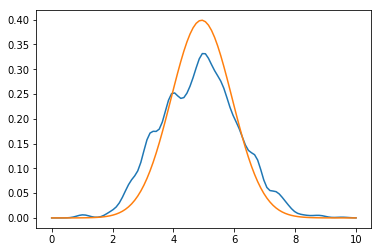

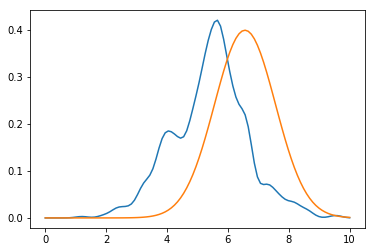

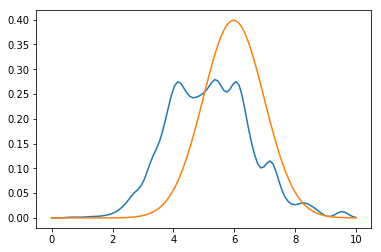

In [5]:
for idx in range(n_test):
  plt.plot(z_grid, density[idx, :])
  plt.plot(z_grid, scipy.stats.norm.pdf(z_grid, sum(x_test[idx, :10]), 1))
  plt.show()

We can also predict conditional means and quantiles

In [8]:
cond_mean = forest.predict_mean(x_test)
print(cond_mean)

[4.8798955  5.41240727 5.21982955]


In [11]:
quantile = 0.25
cond_quants = forest.predict_quantile(x_test, quantile)
print(cond_quants)

[3.95877836 4.66214503 4.17044902]
